In [1]:
import math, os, re, warnings, random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import optimizers, applications, Sequential, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
dir = '/content/drive/MyDrive/data/'
train_dir_path = dir + 'train'
valid_dir_path = dir + 'valid'
test_dir_path = dir + 'test'

In [6]:
IMG_WIDTH, IMG_HEIGHT = 64, 64

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_generator_from_dir(directory_path, batch_size_,test_data=False):

    data_gen = ImageDataGenerator()

    data_batch_generator = data_gen.flow_from_directory(
      directory_path, color_mode = 'rgb', target_size = (IMG_WIDTH, IMG_HEIGHT), 
      batch_size=batch_size_)
  
    return data_batch_generator

In [7]:
BATCH_SIZE=32

In [8]:
train_gen1 = get_generator_from_dir(train_dir_path, BATCH_SIZE)
valid_gen1 = get_generator_from_dir(valid_dir_path, BATCH_SIZE)
test_gen1 = get_generator_from_dir(test_dir_path, 1,True)

Found 2456 images belonging to 2 classes.
Found 0 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [9]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D,Dropout, MaxPooling2D, Dense, Flatten, ZeroPadding2D

def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
   # top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(200, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [10]:
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=2

n_steps = train_gen1.samples // BATCH_SIZE
n_val_steps = valid_gen1.samples // BATCH_SIZE
n_epochs = 20

# create model
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

58889256/58889256 [==============================] - 0s 0us/step


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                            

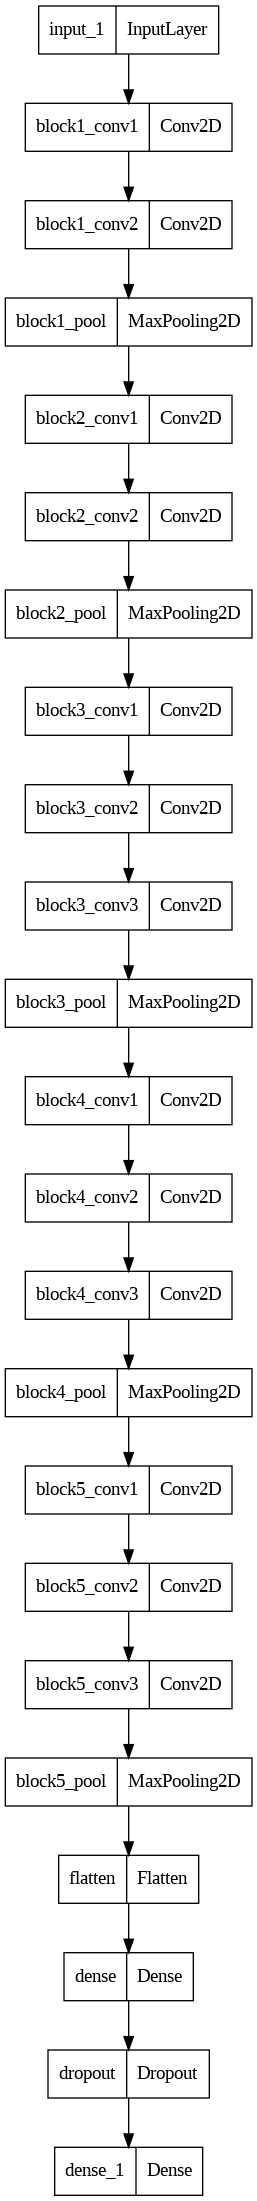

In [19]:
# !pip install pydot
from tensorflow.keras.utils import plot_model

# Prints the model summary
vgg_model.summary()


#Plot the model architecture
plot_model(vgg_model)

In [15]:
#!pip install livelossplot
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/weights/tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

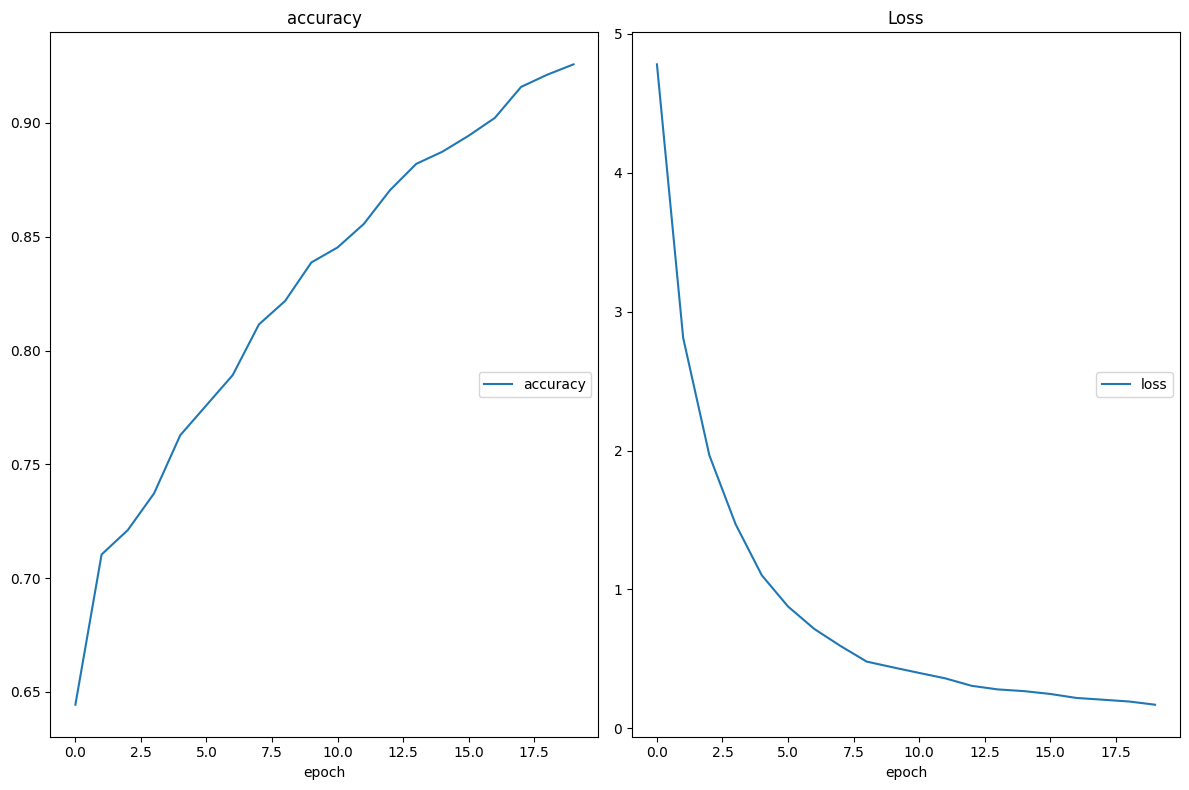

accuracy
	accuracy         	 (min:    0.644, max:    0.926, cur:    0.926)
Loss
	loss             	 (min:    0.171, max:    4.780, cur:    0.171)
76/76 [==============================] - 134s 2s/step - loss: 0.1707 - accuracy: 0.9257


In [16]:
vgg_history = vgg_model.fit(train_gen1,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=valid_gen1,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
vgg_model.load_weights('/content/drive/MyDrive/weights/tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = test_gen1.classes
class_indices = train_gen1.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(test_gen1)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [ ]:
# # Model's performance with test set
# y = vgg_model.evaluate(test_gen1)